Debugging of the LASSI manager products before the tests where we will subtract the recovered Zernike polynomials.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [70]:
import glob
import numpy as np
import pylab as plt

from astropy.io import fits

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

# Load lassi-analysis modules
from parabolas import rotateData
from utils.utils import gridLimits
from zernikies import getZernikeCoeffs
from plotting import barChartPlot, surfacePlot
from analyzeActiveSurface import extractSurface
from lassiAnalysis import maskXYZ, regridXYZMasked, regridXYZ

In [26]:
def load_lassi_fits(filename, n=512):
    
    hdu = fits.open(filename)
    data = hdu[1].data
    x = data['x'].reshape(n,n)
    y = data['y'].reshape(n,n)
    z = data['z'].reshape(n,n)
    
    return x,y,z

In [27]:
n = 512
folder = "/export/simdata/TINT_200212"

In [39]:
reference_file = "{0}/LASSI/{1}".format(folder, "2020_02_12_14:56:00.smoothed.fits")
rx, ry, rz = load_lassi_fits(reference_file, n=512)

In [40]:
signal_file = "{0}/LASSI/{1}".format(folder, "2020_02_12_15:06:32.smoothed.fits")
sx, sy, sz = load_lassi_fits(signal_file, n=512)

In [41]:
pseudoref_file = "{0}/LASSI/{1}".format(folder, "2020_02_12_15:17:43.smoothed.fits")
px, py, pz = load_lassi_fits(pseudoref_file, n=512)

<IPython.core.display.Javascript object>


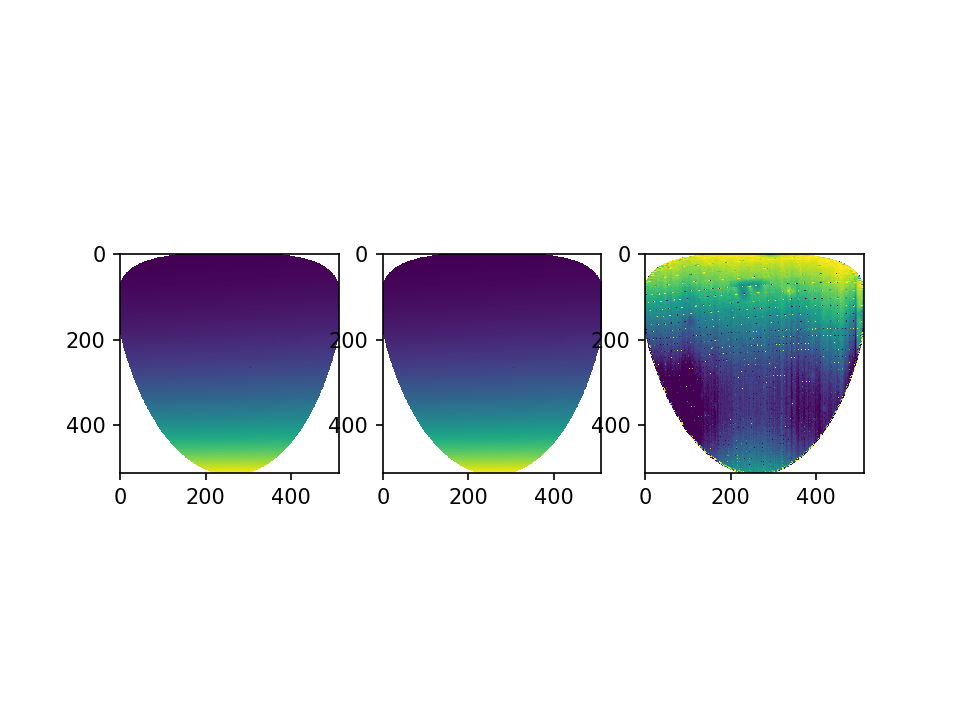

In [43]:
plt.figure(dpi=150)
plt.subplot(131)
plt.imshow(sz)
plt.subplot(132)
plt.imshow(pz)
plt.subplot(133)
plt.imshow(sz-pz, vmin=-3e-3, vmax=1e-3)

In [45]:
pseudoref = maskXYZ(px, py, pz, n=n, guess=[60, 0, 0, -50, 0, 0], radialMask=True, maskRadius=49)

/home/scratch/psalas/LASSI/lassi-analysis_v2/lassiAnalysis.py:367: RuntimeWarning: invalid value encountered in less
  mask = (((xrr - xc)**2. + (yrr - yc)**2.) < maskRadius**2.)
/home/scratch/psalas/LASSI/lassi-analysis_v2/lassiAnalysis.py:396: RuntimeWarning: invalid value encountered in less
  mask = (((xrrm - xc)**2. + (yrrm - yc)**2.) < maskRadius**2.)


In [46]:
ref = maskXYZ(rx, ry, rz, n=n, guess=[60, 0, 0, -50, 0, 0], radialMask=True, maskRadius=49)

/home/scratch/psalas/LASSI/lassi-analysis_v2/lassiAnalysis.py:367: RuntimeWarning: invalid value encountered in less
  mask = (((xrr - xc)**2. + (yrr - yc)**2.) < maskRadius**2.)
/home/scratch/psalas/LASSI/lassi-analysis_v2/lassiAnalysis.py:396: RuntimeWarning: invalid value encountered in less
  mask = (((xrrm - xc)**2. + (yrrm - yc)**2.) < maskRadius**2.)


In [54]:
sig = maskXYZ(sx, sy, sz, n=n, guess=[60, 0, 0, -50, 0, 0], radialMask=True, maskRadius=49)

/home/scratch/psalas/LASSI/lassi-analysis_v2/lassiAnalysis.py:367: RuntimeWarning: invalid value encountered in less
  mask = (((xrr - xc)**2. + (yrr - yc)**2.) < maskRadius**2.)
/home/scratch/psalas/LASSI/lassi-analysis_v2/lassiAnalysis.py:396: RuntimeWarning: invalid value encountered in less
  mask = (((xrrm - xc)**2. + (yrrm - yc)**2.) < maskRadius**2.)


In [51]:
# Extract the data we will use.
xrr, yrr, zrr = ref['rotated']
cr = ref['parabolaFitCoeffs']

xs, ys, zs = pseudoref['origMasked']

# Rotate the signal scan.
xsr, ysr, zsr = rotateData(xs, ys, zs, cr[4], cr[5])
xsr.shape = ysr.shape = zsr.shape = (n,n)
zsr = np.ma.masked_where(zs.mask, zsr)

# The data has been rotated, but we haven't applied the shifts.
xrr = xrr - cr[1]
yrr = yrr - cr[2]
zrr = zrr - cr[3]
xsr = xsr - cr[1]
ysr = ysr - cr[2]
zsr = zsr - cr[3]

# Find the grid limits for the reference and signal scans.
xmin, xmax = gridLimits(xrr, xsr)
ymin, ymax = gridLimits(yrr, ysr)

xrrg, yrrg, zrrg = regridXYZMasked(xrr, yrr, zrr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsrg, ysrg, zsrg = regridXYZMasked(xsr, ysr, zsr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

# Surface deformation map: reference - signal
diff = zrrg - zsrg
diff = diff[::-1] # Flip the signal scan. Required to conform with the way we handle the data.
                  # This should not be required if we handled the data consistently throughout.

# Find Zernike coefficients on the surface deformation map.
fitlist = getZernikeCoeffs(diff.filled(0), 36, barChart=False, norm='active-surface')

<IPython.core.display.Javascript object>


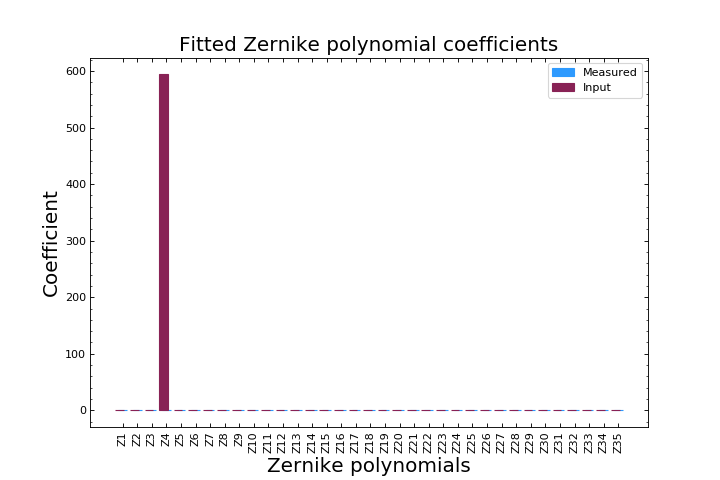

In [52]:
# What are we expecting?
# Based on the active surface fits file.
expected = np.zeros(37)
expected[4] = 594.
# Plot a bar chart with the recovered and expected values.
barChartPlot(np.arange(1,36), np.asarray(fitlist[1:36])*1e6, expected=expected[1:36])
# Show the surface deformation map.
#surfacePlot(x, y, diff, vMin=-5e-3, vMax=5e-3)

In [55]:
# Extract the data we will use.
xrr, yrr, zrr = ref['rotated']
cr = ref['parabolaFitCoeffs']

xs, ys, zs = sig['origMasked']

# Rotate the signal scan.
xsr, ysr, zsr = rotateData(xs, ys, zs, cr[4], cr[5])
xsr.shape = ysr.shape = zsr.shape = (n,n)
zsr = np.ma.masked_where(zs.mask, zsr)

# The data has been rotated, but we haven't applied the shifts.
xrr = xrr - cr[1]
yrr = yrr - cr[2]
zrr = zrr - cr[3]
xsr = xsr - cr[1]
ysr = ysr - cr[2]
zsr = zsr - cr[3]

# Find the grid limits for the reference and signal scans.
xmin, xmax = gridLimits(xrr, xsr)
ymin, ymax = gridLimits(yrr, ysr)

xrrg, yrrg, zrrg = regridXYZMasked(xrr, yrr, zrr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsrg, ysrg, zsrg = regridXYZMasked(xsr, ysr, zsr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

# Surface deformation map: reference - signal
diff = zrrg - zsrg
diff = diff[::-1] # Flip the signal scan. Required to conform with the way we handle the data.
                  # This should not be required if we handled the data consistently throughout.

# Find Zernike coefficients on the surface deformation map.
fitlist2 = getZernikeCoeffs(diff.filled(0), 36, barChart=False, norm='active-surface')

<IPython.core.display.Javascript object>


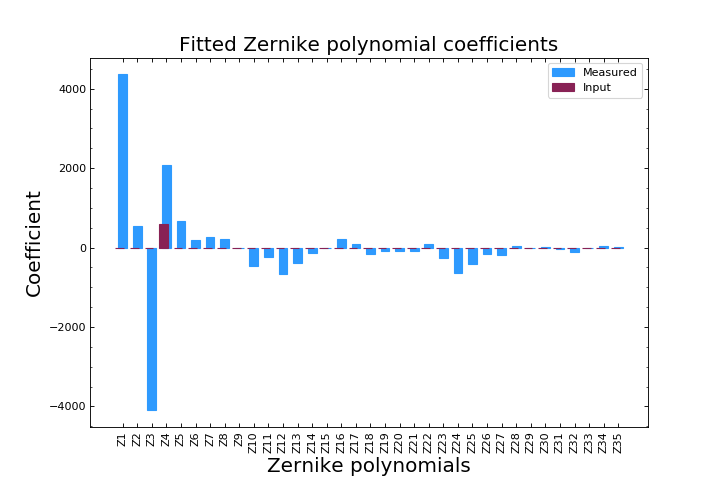

In [58]:
# What are we expecting?
# Based on the active surface fits file.
expected = np.zeros(37)
expected[4] = 594.
# Plot a bar chart with the recovered and expected values.
barChartPlot(np.arange(1,36), np.asarray(fitlist2[1:36])*1e6, expected=expected[1:36])
# Show the surface deformation map.
#surfacePlot(x, y, diff, vMin=-5e-3, vMax=5e-3)

In [63]:
hdu = fits.open("{0}/LASSI/{1}".format(folder, "2020_02_12_15:06:32.zernike.fits"))
zern = hdu[2].data

In [64]:
zern

FITS_rec([( 0,  0.00000000e+00), ( 1,  4.35966477e-03),
          ( 2,  5.52366707e-04), ( 3, -4.10073930e-03),
          ( 4,  2.07050168e-03), ( 5,  6.69685914e-04),
          ( 6,  1.85012863e-04), ( 7,  2.70406302e-04),
          ( 8,  2.06345842e-04), ( 9, -1.34374130e-05),
          (10, -4.59884590e-04), (11, -2.30117094e-04),
          (12, -6.59633074e-04), (13, -3.84881513e-04),
          (14, -1.34997882e-04), (15, -1.33460960e-05),
          (16,  2.11480149e-04), (17,  7.91910702e-05),
          (18, -1.71466061e-04), (19, -8.75508358e-05),
          (20, -9.57612761e-05), (21, -8.58617683e-05),
          (22,  8.18125134e-05), (23, -2.55417426e-04),
          (24, -6.48545431e-04), (25, -4.02366289e-04),
          (26, -1.68985401e-04), (27, -1.75605614e-04),
          (28,  3.39908488e-05), (29, -6.34601899e-06),
          (30,  1.17002771e-05), (31, -3.47935354e-05),
          (32, -1.24759979e-04), (33, -1.78840321e-05),
          (34,  4.64323442e-05), (35,  1.4289951

In [79]:
def proc_active_surface(fn_ref, fn_sig):
    """
    """
    
    print('Commanded thermal Zernike coefficients for the reference file:')
    with fits.open(fn_ref) as hdu:
        print(hdu['THRMZERN'].data)
        
    print('Commanded thermal Zernike coefficients for the signal file:')
    with fits.open(fn_sig) as hdu:
        thrmzern = hdu['THRMZERN'].data
        print(thrmzern)
        
    column = 'INDICATED'
    
    xs, ys, zs = extractSurface(fn_sig, column, dividePhi=True, xy=True, filterDisabled=True, verbose=False)
    xr, yr, zr = extractSurface(fn_ref, column, dividePhi=True, xy=True, filterDisabled=True, verbose=False)

    xxs,yys,aas = regridXYZ(xs, ys, zs)
    xxr,yyr,aar = regridXYZ(xr, yr, zr)

    plt.figure()
    plt.suptitle('Reference - Signal')
    plt.imshow(aar - aas, vmin=-8e-4, vmax=8e-4)

    fitlist = getZernikeCoeffs(np.ma.masked_invalid(aar - aas).T.filled(0), order=36, barChart=True, norm='active-surface')
    
    return aas, aar, fitlist, thrmzern

Commanded thermal Zernike coefficients for the reference file:
[('Z1', 0.) ('Z2', 0.) ('Z3', 0.) ('Z4', 0.) ('Z5', 0.) ('Z6', 0.)
 ('Z7', 0.) ('Z8', 0.) ('Z9', 0.) ('Z10', 0.) ('Z11', 0.) ('Z12', 0.)
 ('Z13', 0.) ('Z14', 0.) ('Z15', 0.) ('Z16', 0.) ('Z17', 0.) ('Z18', 0.)
 ('Z19', 0.) ('Z20', 0.) ('Z21', 0.) ('Z22', 0.) ('Z23', 0.) ('Z24', 0.)
 ('Z25', 0.) ('Z26', 0.) ('Z27', 0.) ('Z28', 0.) ('Z29', 0.) ('Z30', 0.)
 ('Z31', 0.) ('Z32', 0.) ('Z33', 0.) ('Z34', 0.) ('Z35', 0.) ('Z36', 0.)]
Commanded thermal Zernike coefficients for the signal file:
[('Z1',  4.35966486e-03) ('Z2',  5.52366721e-04) ('Z3', -4.10073949e-03)
 ('Z4', -4.99997925e+02) ('Z5',  6.69685891e-04) ('Z6',  1.85012861e-04)
 ('Z7',  2.70406308e-04) ('Z8',  2.06345838e-04) ('Z9', -1.34374131e-05)
 ('Z10', -4.59884584e-04) ('Z11', -2.30117090e-04)
 ('Z12', -6.59633079e-04) ('Z13', -3.84881510e-04)
 ('Z14', -1.34997885e-04) ('Z15', -1.33460962e-05)
 ('Z16',  2.11480146e-04) ('Z17',  7.91910716e-05)
 ('Z18', -1.71466061e-04

<IPython.core.display.Javascript object>


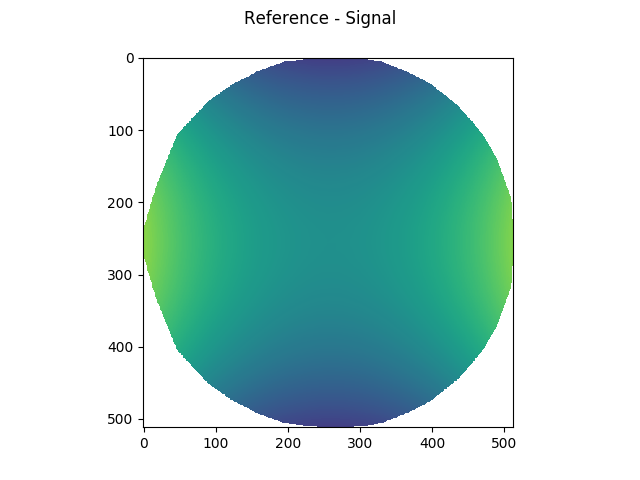

<IPython.core.display.Javascript object>


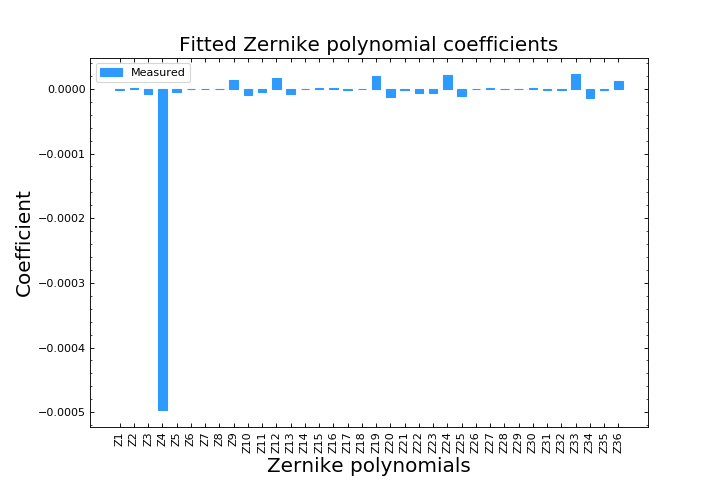

In [80]:
aas1, aar1, fitlist1, thrmzern1 = proc_active_surface("{0}/ActiveSurfaceMgr/{1}".format(folder, "2020_02_12_14:55:47.fits"),
                                                      "{0}/ActiveSurfaceMgr/{1}".format(folder, "2020_02_12_15:17:30.fits"))

In [74]:
fitlist1[4]

-0.0004972553747601641

In [77]:
500 - fitlist2[4]

499.997929498316

In [83]:
thrmzern1[3][1]

-499.9979248046875

The Zernikes are subtracted at the right position (Z4), however the units are different (AS uses microns and LASSI outputs meters).